### 1. Activate the IceFloeTracker package

First activate the project environment, load things, and set up some paths.

In [7]:
using IceFloeTracker
using Images: load, Gray, channelview

ERROR: LoadError: syntax: { } vector syntax is discontinued around /project/IceFloeTracker.jl/src/landmask.jl:46
Stacktrace:
 [1] top-level scope
   @ /project/IceFloeTracker.jl/src/landmask.jl:46
 [2] include(mod::Module, _path::String)
   @ Base ./Base.jl:557
 [3] include(x::String)
   @ IceFloeTracker /project/IceFloeTracker.jl/src/IceFloeTracker.jl:1
 [4] top-level scope
   @ /project/IceFloeTracker.jl/src/IceFloeTracker.jl:61
 [5] include
   @ ./Base.jl:557 [inlined]
 [6] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
   @ Base ./loading.jl:2881
 [7] top-level scope
   @ stdin:6
in expression starting at /project/IceFloeTracker.jl/src/landmask.jl:46
in expression starting at /project/IceFloeTracker.jl/src/IceFloeTracker.jl:1
in expression starting at stdin:6


ErrorException: Failed to precompile IceFloeTracker [04643c7a-9ac6-48c5-822f-2704f9e70bd3] to "/home/vscode/.julia/compiled/v1.11/IceFloeTracker/jl_GoBu3u".

## 1. Landmask generation

In [2]:
coastline = load("landmask.tiff")
(not_land_dilated, not_land) = create_landmask(coastline)
Gray.(not_land)

UndefVarError: UndefVarError: `load` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## 2. Preprocessing

Load a pair of truecolor/reflectance images

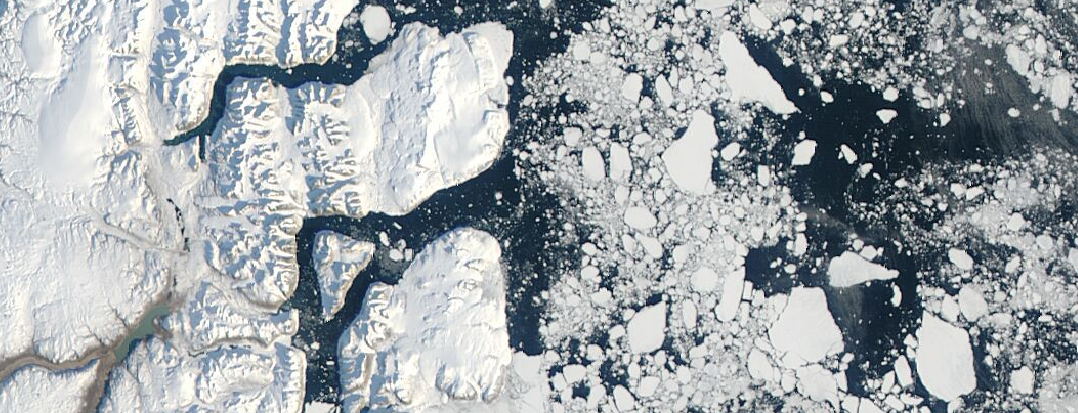

In [6]:
modis_143 = load("truecolor.tiff")

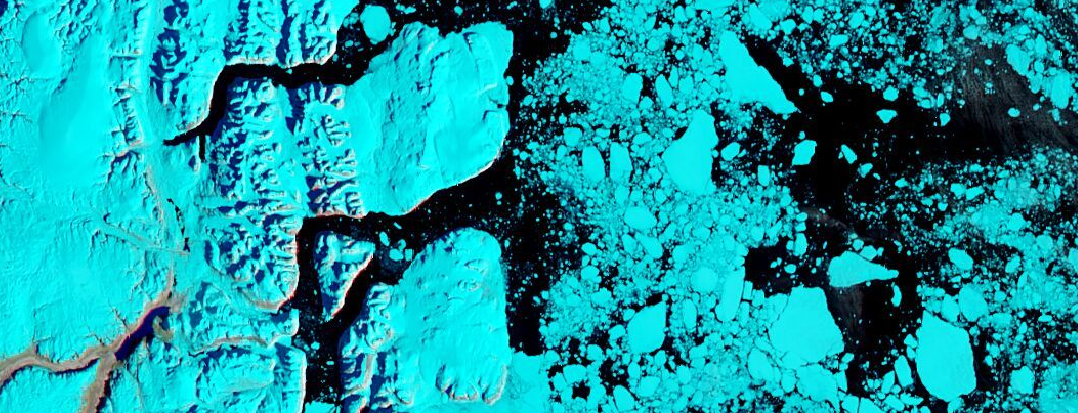

In [7]:
modis_721 = load("falsecolor.tiff")

Cloudmask generation

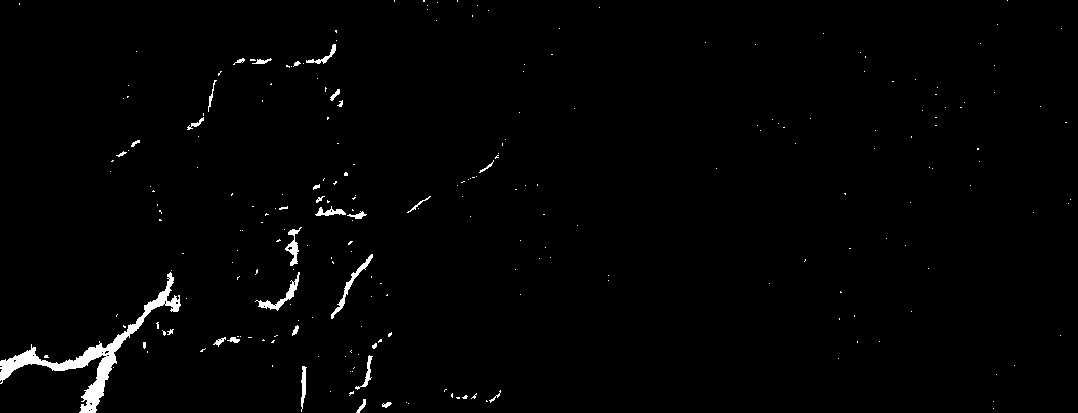

In [10]:
# Create cloudmask from reflectance image
cloud = create_cloudmask(
    modis_721;
    prelim_threshold=110 / 255,
    band_7_threshold=200 / 255,
    band_2_threshold=190 / 255,
    ratio_lower=0.0,
    ratio_upper=0.75)

### 3. Create intermediate images for segmentation

In [11]:
#= ice 
   This mask shows pixels where there is obvious ice.=#

ice = IceFloeTracker.find_ice(
   modis_721,
   not_land_dilated;
   band_7_threshold=5 / 255,
   band_2_threshold = 230 / 255,
   band_1_threshold = 240 / 255,
   band_7_threshold_relaxed = 10 / 255,
   band_1_threshold_relaxed = 190 / 255,
   possible_ice_threshold = 75 / 255,
)

TypeError: TypeError: non-boolean (Gray{Bool}) used in boolean context

Sharpening

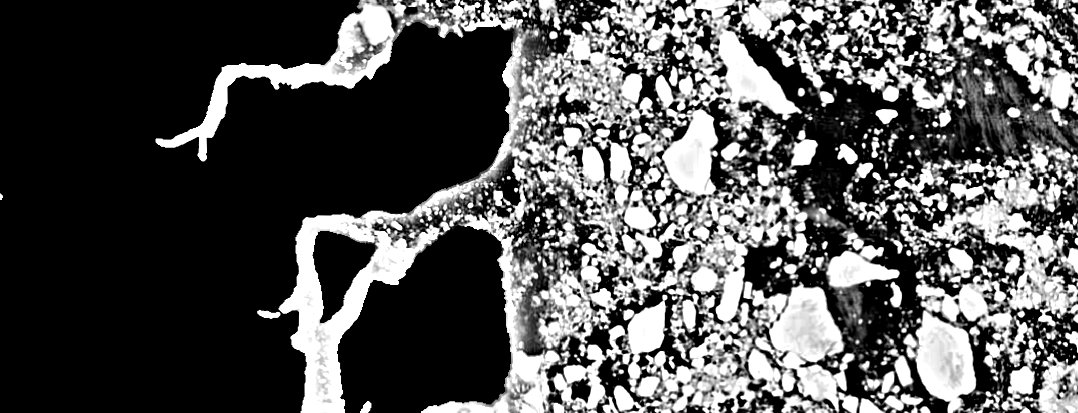

In [7]:
# a. apply imsharpen to truecolor image using non-dilated landmask
sharpened_truecolor_image = IceFloeTracker.imsharpen(
    modis_143, 
    not_land; 
    lambda=0.1,
    kappa = 75,
    niters = 3,
    nbins = 255,
    rblocks = 10,
    cblocks = 10,
    clip = 0.86,
    smoothing_param = 10,
    intensity = 2.0
)

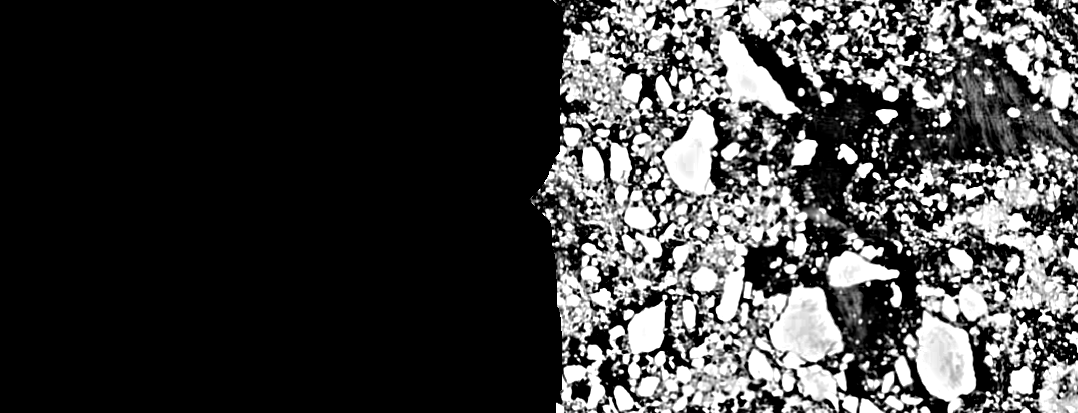

In [8]:
# b. apply imsharpen to sharpened truecolor img using dilated landmask
sharpened_gray_truecolor_image_landfast_masked = IceFloeTracker.apply_landmask(sharpened_truecolor_image, not_land_dilated)

Normalization

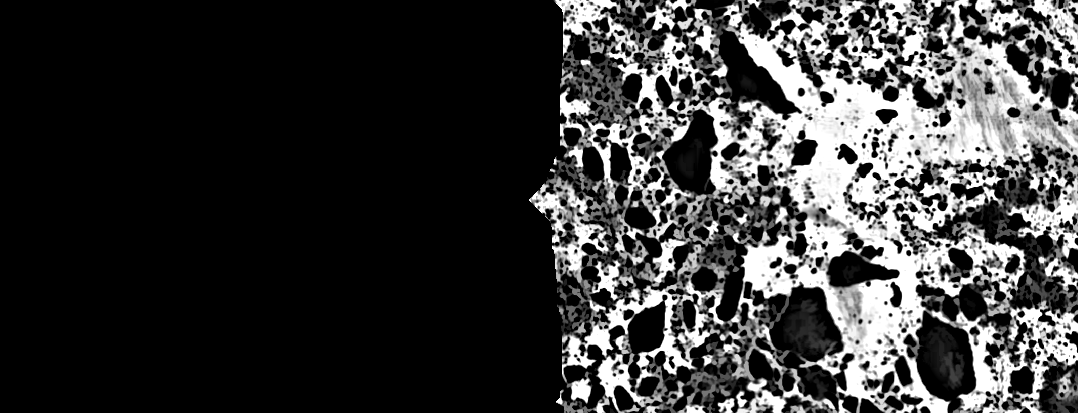

In [9]:
# Normalization
normalized_image = IceFloeTracker.normalize_image(
    sharpened_truecolor_image, sharpened_gray_truecolor_image_landfast_masked, not_land_dilated)

Ice water discrimination

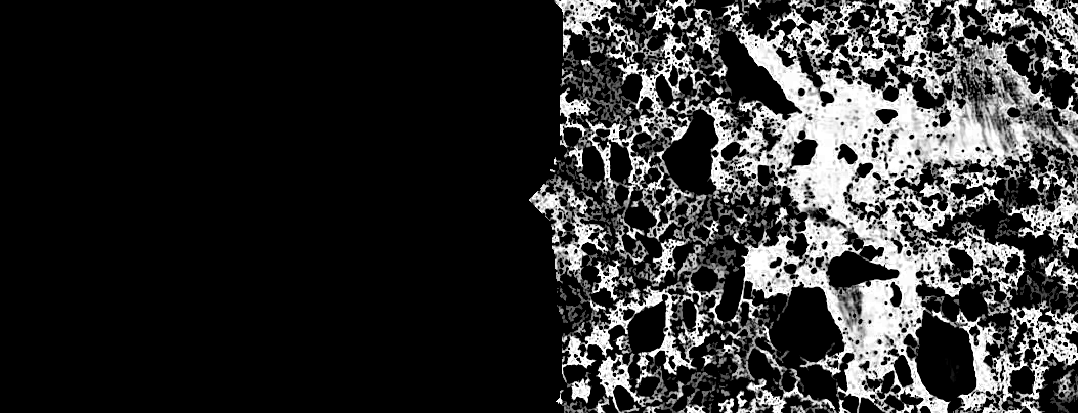

In [10]:
#= Icewater discrimination =#

ice_water_discrim = IceFloeTracker.discriminate_ice_water(
    modis_721, 
    normalized_image, 
    not_land_dilated,
    cloud; 
    floes_threshold=100 / 255,
    mask_clouds_lower = 17 / 255,
    mask_clouds_upper = 30 / 255,
    kurt_thresh_lower = 2,
    kurt_thresh_upper = 8,
    skew_thresh = 4,
    st_dev_thresh_lower = 84 / 255,
    st_dev_thresh_upper = 98.9 / 255,
    clouds_ratio_threshold = 0.02,
    differ_threshold = 0.6,
    nbins = 155,
    )


## 4. Segmentation

In [11]:
# segmentation_A
segmented_ice_cloudmask = IceFloeTracker.segmented_ice_cloudmasking(
    ice_water_discrim, cloud, ice
)

MethodError: MethodError: no method matching segmented_ice_cloudmasking(::Matrix{Gray{Float64}}, ::BitMatrix, ::Matrix{Gray{Bool}})
The function `segmented_ice_cloudmasking` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  segmented_ice_cloudmasking(::AbstractArray{<:Gray}, !Matched::AbstractArray{<:Gray}, ::AbstractArray{<:Gray})
   @ IceFloeTracker /project/IceFloeTracker.jl/src/segmentation_a_direct.jl:75
  segmented_ice_cloudmasking(::AbstractArray{<:Gray}, !Matched::AbstractArray{<:Gray}, !Matched::Vector{Int64})
   @ IceFloeTracker /project/IceFloeTracker.jl/src/segmentation_a_direct.jl:65


In [17]:
segA = IceFloeTracker.segmentation_A(segmented_ice_cloudmask)

413×1078 BitMatrix:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱              ⋮              ⋮     
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0 

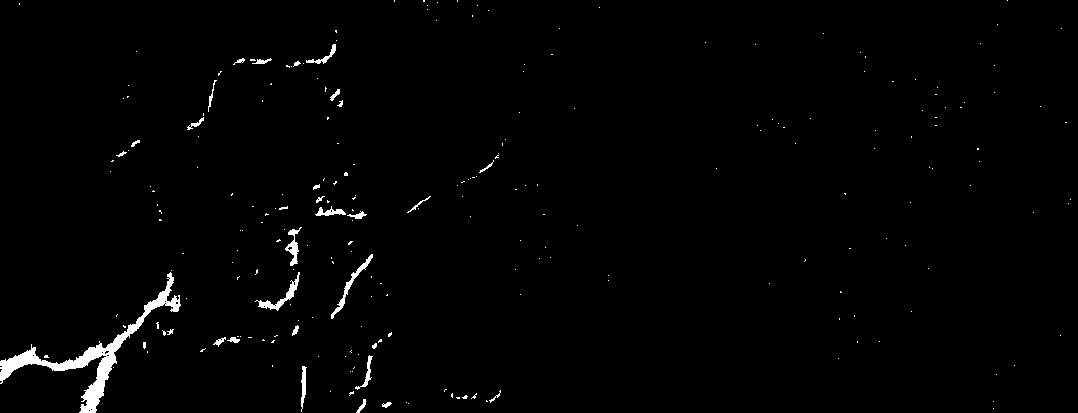

In [19]:
Gray.(segA)

### Note
Here is the first significant source of error introduced due to the implementation of the kmeans algorithm used for the package. For details see `src/segmentation_a_direct.jl` and/or https://juliastats.org/Clustering.jl/dev/kmeans.html#Clustering.kmeans.

In [ ]:
# Test segmentation_A
segA_expected = convert(BitMatrix,float64.(load(joinpath(TEST,"test_inputs/matlab_segmented_A.png"))))
@assert test_similarity(segA_expected, segA, 0.1005)

In [ ]:
@time segB = IceFloeTracker.segmentation_B(sharpened_gray_truecolor_image, cloudmask, segA)
# 1.264987 seconds (24.14 M allocations: 1.041 GiB, 0.36% compilation time)

In [ ]:
# Test segmentation_B
matlab_ice_intersect = convert(
        BitMatrix, load(joinpath(TEST,"test_inputs/matlab_segmented_c.png")
    ))

    matlab_not_ice_mask = float64.(load(joinpath(TEST,"test_inputs/matlab_I.png")))

@assert (@test_approx_eq_sigma_eps segB.not_ice matlab_not_ice_mask [0, 0] 0.055) === nothing
@assert test_similarity((matlab_not_ice_mask .> 0.499), segB.not_ice_bit, 0.05)
@assert test_similarity(matlab_ice_intersect, segB.ice_intersect, 0.08)

In [ ]:
imshow(segB.not_ice)

In [ ]:
imshow(segB.not_ice_bit)

In [ ]:
imshow(segB.ice_intersect)

In [ ]:
# Generate watersheds
@everywhere using IceFloeTracker: watershed_ice_floes
@time watersheds_segB = pmap(IceFloeTracker.watershed_ice_floes, [segB.not_ice_bit, segB.ice_intersect])
# 423.326505 seconds (6.43 M allocations: 327.860 GiB, 8.08% gc time, 0.53% compilation time)

In [ ]:
watershed_intersect = IceFloeTracker.watershed_product(watersheds_segB...)

In [ ]:
# Test watershed_intersect
matlab_watershed_D = convert(BitMatrix, load(joinpath(TEST,"test_inputs/matlab_watershed_D.png")))
matlab_watershed_E = convert(BitMatrix, load(joinpath(TEST,"test_inputs/matlab_watershed_E.png")))
matlab_watershed_intersect = convert(BitMatrix, load(joinpath(TEST,"test_inputs/matlab_watershed_intersect.png")))

## Tests with Matlab inputs
@assert test_similarity(matlab_watershed_D, watersheds_segB[1], 0.15)
@assert test_similarity(matlab_watershed_E, watersheds_segB[2], 0.15)
@assert test_similarity(matlab_watershed_intersect, watershed_intersect , 0.033)

In [ ]:
@time isolated_floes = IceFloeTracker.segmentation_F(
    segB.not_ice,
    segB.ice_intersect,
    watershed_intersect,
    ice_labels,
    cloudmask,
    landmask_imgs.dilated,
)
# 445.557423 seconds (2.81 G allocations: 89.153 GiB, 2.79% gc time, 0.00% compilation time)

In [ ]:
# Test isolated_floes
matlab_BW7 = load(joinpath(TEST,"test_inputs/matlab_BW7.png")) .> 0.499

@assert test_similarity(matlab_BW7, isolated_floes, 0.143)

@assert test_similarity(matlab_BW7[ice_floe_test_region...], isolated_floes[ice_floe_test_region...], 0.0705)
